# Homework 2

## FINM 37400 - 2023

## Group: Yuna Ge, Anvita Panandikar, Charlotte Wang, Zixin Zhang

***

## Imports

In [4]:
import pandas as pd
import numpy as np
import datetime
import warnings

# from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import sys
sys.path.insert(0, '../cmds')

from scipy import optimize
from scipy import interpolate
from treasury_cmds import *
pd.options.display.float_format = '{:,.4f}'.format

ModuleNotFoundError: No module named 'sklearn'

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (A): US Treasuries in November 2008

## Data
* Use the data file `treasury_ts_2015-08-15.xlsx`.
* Examine the treasure issues with `kytreasno` of `204046` and `204047`. These are the bond and note (respectively) which mature on 2015-08-15.
* Look at the data on 2008-11-04.

In [ ]:
QUOTE_DATE = '2015-08-15'

filepath_tsdata = f'treasury_ts_{QUOTE_DATE}.xlsx'
rawdata_full = pd.read_excel(filepath_tsdata,sheet_name='database')
rawdata_full.columns = rawdata_full.columns.str.upper()
rawdata_full = rawdata_full.loc[rawdata_full['KYTREASNO'].isin([204046, 204047])]
rawdata_full.set_index('KYTREASNO',inplace=True)
rawdata = rawdata_full[rawdata_full['CALDT'] == '2008-11-04']

rawdata

,KYCRSPID,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,TDDURATN,TDPUBOUT,TDTOTOUT,TDPDINT,TDIDXRATIO,TDIDXRATIO_FLG
KYTREASNO,,,,,,,,,,,,,,,,
204047,"20,150,815.2043",2008-11-04,105.9531,105.9844,105.9688,M,X,0.9355,0.0116,0.0001,"2,168.0166","20,998.0000","32,470.0000",0.0000,NaN,NaN
204046,"20,150,815.1106",2008-11-04,141.8594,141.8906,141.8750,M,X,2.3387,0.0097,0.0001,"1,910.3079","2,852.0000","4,024.0000",0.0000,NaN,NaN


## 1.1 The situation

Make a chart comparing the issues in the following features, (as of Nov 4, 2008.)
* coupon rate
* bid
* ask
* accrued interest
* dirty price
* duration (quoted in years, not days, assuming 365.25 days per year.)
* modified duration
* YTM

In [ ]:
summary = pd.DataFrame(index=rawdata.index)

summary.loc[204047, 'Coupon Rate'] = 4.25
summary.loc[204046, 'Coupon Rate'] = 10.625
summary['Bid'] = rawdata['TDBID']
summary['Ask'] = rawdata['TDASK']
summary['Accrued Interest'] = rawdata['TDACCINT']
summary['Dirty Price'] = (rawdata['TDBID'] + rawdata['TDASK'])/2 + rawdata['TDACCINT']
summary['Duration'] = rawdata['TDDURATN']/365.25
summary['Modified Duration'] = summary['Duration'] / (1 + rawdata['TDYLD'] * 365 / 2)
summary['YTM'] = rawdata['TDYLD'] * 365

summary

,Coupon Rate,Bid,Ask,Accrued Interest,Dirty Price,Duration,Modified Duration,YTM
KYTREASNO,,,,,,,,
204047,4.2500,105.9531,105.9844,0.9355,106.9042,5.9357,5.8413,0.0323
204046,10.6250,141.8594,141.8906,2.3387,144.2137,5.2301,5.1383,0.0357


## 1.2 Hedge Ratio

Suppose you are building a trade to go long $n_i$ bonds (`204046`) and short $n_j$ notes (`204047`).

We can find an equation for $n_j$ in terms of $n_i$ such that the total holdings will have duration equal to zero. (Having zero duration also means have zero dollar duration, if helpful.)

Notation:
* $n_i$: number of bonds purchased (or sold)
* $D_i$: duration of bond $i$
* $D_{\$,i}$: dollar duration of bond $i$, equal to $p_iD_i$

If we want the total duration of our holdings to be zero, then we need to size the trade such that $n_i$ and $n_j$ satisfy,

$$0 = n_iD_{\$,i} + n_jD_{\$,j}$$

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Suppose you will use \\$1mm of capital, leveraged 50x to buy \\$50mm of the bonds (`204046`).

Use the ratio above to short a number of notes (`204047`) to keep zero duration.

Report the number of bonds and notes of your position, along with the total dollars in the short position.

In [ ]:
dd_bonds = summary.loc[204046, 'Dirty Price'] * rawdata.loc[204046, 'TDDURATN']
dd_notes = summary.loc[204047, 'Dirty Price'] * rawdata.loc[204047, 'TDDURATN']
num_bonds = 50_000_000 / summary.loc[204046, 'Dirty Price']
num_notes = num_bonds * dd_bonds / dd_notes

In [ ]:
print(f"Number of bonds: {num_bonds:,.4f}")

Number of bonds: 346,707.8068


In [ ]:
print(f"Number of notes: {num_notes:,.4f}")

Number of notes: 412,112.6579


In [ ]:
print(f"Total dollars in short position: {num_notes * summary.loc[204047, 'Dirty Price']:,.4f}")

Total dollars in short position: 44,056,578.9301


## 1.3 Profit Opportunity

Using the concept of **modified duration**, how much profit or loss (PnL) would you expect to make for every basis point of convergence in the spread? Specifically, assume the convergence is symmetric: the bond's (`204046`) ytm goes down 0.5bp and the note (`204047`) ytm goes up 0.5bp.

Describe the PnL you would expect to achieve on your position should this happen. Specify the PnL of the long position, the short position, and the net total.

**Answer:**
- Modified duration tells us how much the price of the bond will change if there is a change of 100bp in YTM
    - For 204046: 100bp decrease will increase the price by 5.23%
    - For 204047: 100bp increase will decrease the price by 5.94%
- If bond's (`204046`) ytm goes down 0.5bp, the price will increase by 0.02615%
- If note (`204047`) ytm goes up 0.5bp, the price will decrease by 0.0297%
- PnL of long position: 352,384.0987 * 0.02615% * Ask Price = 13,075
- PnL of short position: 415,689.3781 * 0.0297% * Ask Price = 13,084.8
- Net PnL: 13,075 + 13,084.8 = 26,159.8

Suppose the spread in YTM between the two securities disappears, due to a symmetric move of roughly ~17bps in each security's YTM. What is the PnL? (This is just a linearly scaling of your prior answer for a 1bp convergence.) 

**Answer:**
- Net PnL = 26,159.8 * 17 / 0.5 = 889,433.2

In [ ]:
pnl_long_1 = num_bonds * 0.02615 * summary.loc[204046, 'Dirty Price'] / 100
print(f"PnL of long position (0.5bps): {pnl_long_1:,.4f}")

PnL of long position (0.5bps): 13,075.0000


In [ ]:
pnl_short_1 = num_notes * 0.0297 * summary.loc[204047, 'Dirty Price'] / 100
print(f"PnL of short position (0.5bps): {pnl_short_1:,.4f}")

PnL of short position (0.5bps): 13,084.8039


In [ ]:
net_pnl_1 = pnl_long_1 + pnl_short_1
print(f"Net PnL (0.5bps): {net_pnl_1:,.4f}")

Net PnL (0.5bps): 26,159.8039


In [ ]:
net_pnl_2 = net_pnl_1 * 17 / 0.5
print(f"Net PnL (17bps): {net_pnl_2:,.4f}")

Net PnL (17bps): 889,433.3340


## 1.4 Result in 2008

Calculate the profit (or loss) on the position on the following two dates:
* 2008-11-25
* 2008-12-16

To calculate the pnl on each date, simply use the prices of the securities on those dates along with your position sizes, ($n_i, n_j$). No coupon is being paid in November or December, so all you need is the "dirty" price on these two dates.

Does the pnl make sense (approximately) given your results in 1.3 with regard to the sensitivity of pnl to moves in the YTM spread?

**Answer:**
- The loss in this case makes sense, since for 2008-11-25 both the bond and note's YTM went down by ~0.5bps instead of converging. Likewise for 2008-12-16, both the bond and note's YTM went down by ~1.7bps instead of converging.
- If the spread had converged, we would have observed a profit similar to the result in 1.3

In [ ]:
rawdata_1 = rawdata_full[rawdata_full['CALDT'] == '2008-11-25']
dirty_price_1 = (rawdata_1['TDBID'] + rawdata_1['TDASK'])/2 + rawdata_1['TDACCINT']

pnl_bonds_1 = num_bonds * (dirty_price_1[204046] - summary.loc[204046, 'Dirty Price'])
pnl_notes_1 = -num_notes * (dirty_price_1[204047] - summary.loc[204047, 'Dirty Price'])
pnl_1 = pnl_bonds_1 + pnl_notes_1
print(f"Net PnL (2008-11-25): {pnl_1:,.4f}")

Net PnL (2008-11-25): -499,072.8163


In [ ]:
rawdata_2 = rawdata_full[rawdata_full['CALDT'] == '2008-12-16']
dirty_price_2 = (rawdata_2['TDBID'] + rawdata_2['TDASK'])/2 + rawdata_2['TDACCINT']

pnl_bonds_2 = num_bonds * (dirty_price_2[204046] - summary.loc[204046, 'Dirty Price'])
pnl_notes_2 = -num_notes * (dirty_price_2[204047] - summary.loc[204047, 'Dirty Price'])
pnl_2 = pnl_bonds_2 + pnl_notes_2
print(f"Net PnL (2008-12-16): {pnl_2:,.4f}")

Net PnL (2008-12-16): -1,049,332.7543


In [ ]:
ytm_change_1 = (rawdata_1['TDYLD'] * 365 - summary['YTM'])
print(f"YTM Change (2008-11-25): {ytm_change_1}")

YTM Change (2008-11-25): KYTREASNO
204047   -0.0076
204046   -0.0057
dtype: float64


In [ ]:
ytm_change_2 = (rawdata_2['TDYLD'] * 365 - summary['YTM'])
print(f"YTM Change (2008-12-16): {ytm_change_2}")

YTM Change (2008-12-16): KYTREASNO
204047   -0.0176
204046   -0.0138
dtype: float64


***

# 2 Calculating Duration

Use the data file `../data/treasury_quotes_2022-09-30.xlsx`.

This data reports duration as `Use the data file `../data/treasury_quotes_2022-09-30.xlsx`.

This data reports duration as `TDDURATN`. It quotes the duration in days, so I recommend dividing by 365 to get the duration in its usual format.

In [ ]:
QUOTE_DATE = '2022-09-30'

filepath_rawdata = f'treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)
rawdata['TDDURATN'] = rawdata['TDDURATN']/365

rawdata.tail()

,KYCRSPID_X,CALDT,TDBID,TDASK,TDNOMPRC,TDNOMPRC_FLG,TDSOURCR,TDACCINT,TDRETNUA,TDYLD,...,TFCALDT,TNOTICE,IYMCN,ITYPE,IUNIQ,ITAX,IFLWR,TBANKDT,TSTRIPELIG,TFRGNTGT
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207808,20511115.101870,2022-09-30,65.9141,65.9609,65.9375,M,I,0.7031,-0.0109,0.0001,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207849,20520215.102250,2022-09-30,72.4062,72.4688,72.4375,M,I,0.2812,-0.0104,0.0001,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207850,20520215.C00120,2022-09-30,62.7812,63.0391,62.9102,M,I,0.0000,NaN,NaN,...,NaN,0,NaN,12,0,1,1,NaN,NaN,NaN
207891,20520515.102870,2022-09-30,83.6172,83.6797,83.6484,M,I,1.0781,-0.0097,0.0001,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN
207934,20520815.103000,2022-09-30,86.1016,86.1641,86.1328,M,I,0.3750,-0.0096,0.0001,...,NaN,0,NaN,1,0,1,1,NaN,NaN,NaN


## 2.1 
Set up the cashflow matrix. 

In [ ]:
CF = calc_cashflows(rawdata)
display(CF)

,2022-10-04,2022-10-06,2022-10-11,2022-10-13,2022-10-15,2022-10-18,2022-10-20,2022-10-25,2022-10-27,2022-10-30,...,2050-05-15,2050-08-15,2050-11-15,2051-02-15,2051-05-15,2051-08-15,2051-11-15,2052-02-15,2052-05-15,2052-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
207892,100,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207774,0,100,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207893,0,0,100,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207868,0,0,0,100,0.0000,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
207430,0,0,0,0,100.6875,0,0,0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207808,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.9375,0.0000,0.9375,0.0000,0.9375,0.0000,100.9375,0.0000,0.0000,0.0000
207849,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,1.1250,0.0000,1.1250,0.0000,1.1250,0.0000,101.1250,0.0000,0.0000
207850,0,0,0,0,0.0000,0,0,0,0,0.0000,...,0.0000,0.0625,0.0000,0.0625,0.0000,0.0625,0.0000,100.0625,0.0000,0.0000


## 2.2
Build a discount curve assuming that the spot rate is 2\% per year, continuously compounded.

Plot the discount curve and the associated spot curve out to 30 years maturity.

*Note, you do not need to properly extract a spot curve and associated discount factors; rather, you are simply assuming a flat term structure of spot rates at 2\% and using that to figure out discount rates.*

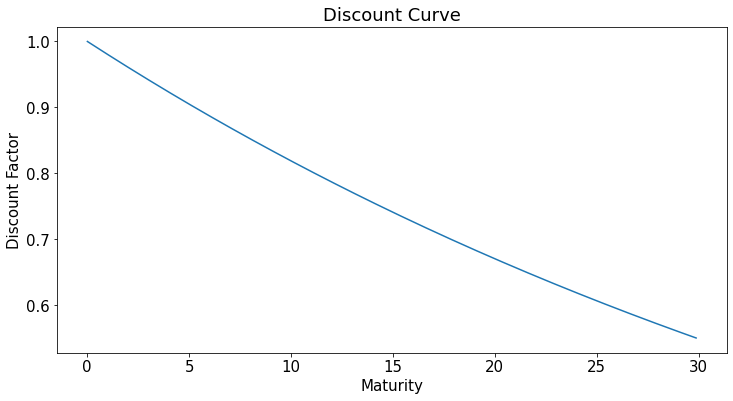

In [ ]:
rate = 0.02
t_current = rawdata['CALDT'].values[0]
maturities = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values

disc_rate = pd.DataFrame(index=maturities,columns=['Discount'],dtype=float)
for t in maturities:
    disc_rate.loc[t,'Discount'] = intrate_to_discount(rate, t)
    
plt.plot(maturities,disc_rate['Discount'])
plt.xlabel('Maturity')
plt.ylabel('Discount Factor')
plt.title('Discount Curve')
plt.show()

## 2.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)

In [ ]:
CF_prices = CF * list(disc_rate['Discount'])
model_prices = CF_prices.sum(axis=1)
CF_wts = CF_prices.div(model_prices,axis=0)

CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current)
duration = pd.DataFrame((CF_wts * CF_intervals).sum(axis=1), columns=['Calculated Duration'])

duration.describe()

,Calculated Duration
count,427.0000
mean,5.5796
std,6.3805
min,0.0110
25%,1.0262
50%,3.1077
75%,6.2790
max,28.6180


## 2.4
How close are your duration estimates to the imputed durations given in the data source, (column `TDDURATN`)?

Report the summary statistics of the imputed durations minus your calculated durations from above.

Why might they be different?

**Answer:**
- On average, the calculated duration estimates are 0.21 higher than the imputed durations with the difference between the two having a standard deviation of 0.47
- The difference is observed because the imputed duration refers to the Macauley duration (response to a parallel shift in the spot curve) whereas the calculated duration is a weighted average of the discounted cashflow maturity

In [ ]:
duration['Imputed Duration'] = rawdata['TDDURATN']
duration['Difference'] = duration['Imputed Duration'] - duration['Calculated Duration']

duration.describe()

,Calculated Duration,Imputed Duration,Difference
count,427.0000,378.0000,378.0000
mean,5.5796,4.9413,-0.2094
std,6.3805,5.5822,0.4663
min,0.0110,0.0110,-1.9455
25%,1.0262,0.8830,-0.0301
50%,3.1077,2.7510,-0.0005
75%,6.2790,5.9636,0.0004
max,28.6180,21.4285,0.0017


## 2.5
Continue using your assumed discount rates of 2\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

In [ ]:
convexity_intervals = CF_intervals ** 2

convexity = pd.DataFrame((CF_wts * convexity_intervals).sum(axis=1), columns=['Calculated Convexity'])

convexity.describe()

,Calculated Convexity
count,427.0000
mean,81.7060
std,155.3870
min,0.0001
25%,1.0537
50%,9.9499
75%,41.9653
max,833.9085


***

# 3 Hedging Duration

Import `treasury_ts_issue_duration_(207392, 207391, 207457).xlsx`.

I suggest using code such as

* `tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')`

* `tsdata.columns = tsdata.columns.str.upper()`

* `px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()`
* `duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()`

In [ ]:
filepath_tsdata = f'treasury_ts_issue_duration_(207392, 207391, 207457).xlsx'

tsdata = pd.read_excel(filepath_tsdata,sheet_name='ts')
tsdata.columns = tsdata.columns.str.upper()
px = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDASK').dropna()
duration = tsdata.pivot_table(index='CALDT',columns='KYTREASNO',values='TDDURATN').dropna()

## 3.1 

Suppose you have a portfolio of 10,000 USD long in security `207391` on the last day of the sample.

If you want to manage interest rate exposure using duration, how large of a short position should you hold in `207392`?

(Duration is the column `TDDURATN` in the raw data.)

**Answer:**
- Based on the below calculation, if we want to manage interest rate exposure using duration, we will hold 41.239 shares or 3,457.62 USD short in security `207392`

In [ ]:
px.tail(1)

KYTREASNO,207391,207392,207457
CALDT,,,
2022-05-31,92.1719,83.8438,100.0547


In [ ]:
duration.tail(1)

KYTREASNO,207391,207392,207457
CALDT,,,
2022-05-31,"2,475.5494","7,159.6981",196.5257


In [ ]:
10000 * duration.iloc[-1][207391] / (px.iloc[-1][207392] * duration.iloc[-1][207392])

41.23881632503426

In [ ]:
10000 * duration.iloc[-1][207391] / duration.iloc[-1][207392]

3457.6170062520914

## 3.2

Step through the time-series, doing the following:

* Starting at the end of the first day, set the hedged position according to the relative given durations.
* Use the second day's price data to evaluate the net profit or loss of the hedged position.
* Reset the the hedged position using the end-of-second-day durations. Again fix the long position of security `207391` to be 10,000.
* Repeat throughout the timeseries.

Report 
* the total profit (or loss.)
* the mean, standard deviation, min, and max of the daily profit or loss.

In [ ]:
pnl = pd.DataFrame(data=None, index=duration.index)
price_change = px.shift() - px

pnl['207391 Shares'] = 10000 / px[207391]
pnl['207392 Shares'] = 10000 * duration[207391] / (px[207392] * duration[207392])
pnl['PnL'] = pnl['207391 Shares'].shift() * price_change[207391] - pnl['207392 Shares'].shift() * price_change[207392]
pnl

,207391 Shares,207392 Shares,PnL
CALDT,,,
2019-12-10,101.9677,41.4669,NaN
2019-12-11,101.5148,41.0494,-9.9471
2019-12-12,102.4246,41.9388,14.7441
2019-12-13,101.7893,41.2905,-8.6809
2019-12-16,102.1956,41.6440,8.4710
...,...,...,...
2022-05-24,107.7895,40.4107,-22.1890
2022-05-25,107.6716,40.3172,-4.9489
2022-05-26,107.6807,40.6285,-21.5223


In [ ]:
print(f"Total profit: {pnl['PnL'].sum():,.4f}")

Total profit: 240.9097


In [ ]:
pnl['PnL'].describe()

count    620.0000
mean       0.3886
std       18.7976
min     -107.6361
25%       -9.2502
50%        0.0779
75%        9.7767
max       98.3180
Name: PnL, dtype: float64

***